<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 3 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Lucas Liu
- <b>Student ID:</b> 31445179

<div class="alert alert-block alert-danger">

# Table of Contents

* [Libraries](#Libraries)
    
* [Task 3.1: Download the GTSRB Train and Test set](#t3_1)
    
* [Task 3.2: Visualise a few training samples](#t3_2)
    
* [Task 3.3: Define a CNN Model](#t3_3)
    
* [Task 3.4: Train and evaluate CNN model](#t3_4)
    
* [Task 3.5: Visualise the results](#t3_5)
    
* [Task 3.6: Discussion Questions](#t3_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [1]:
# Mount Google Drive
import os

try:
    from google.colab import drive

    colabFlag = True

    PATH_DATASETS = "/content/gdrive/MyDrive/..."  # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount("/content/gdrive")
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [2]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
from torchvision.datasets import GTSRB
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy

import pytorch_lightning as pl  # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# from carbontracker.tracker import CarbonTracker
from torch.optim.lr_scheduler import StepLR

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else "cpu")
num_workers = 0  # Set to your device
print(torch.cuda.get_device_name(device))

Seed set to 4179


AMD Radeon RX 7900 XTX


<div class="alert alert-block alert-info">
    
# Image Classification on the GTSRB dataset
    
# What you should do in this task!

In this task you will be training a Convolutional Neural Network (CNN) with the GTSRB dataset using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt datasets, the Pytorch Lightning module class to construct MLP and CNN, and stochastic gradient descent (SGD) in order to perform training on the GTSRB dataset.
    
## In this task, you will work on the following points:
 1. Download the GTSRB Train and Test set
 2. Visualise a few training samples
 3. Define a CNN Model
 4. Train and evaluate CNN model
 5. Visualise the results and apply additional analysis here
 6. Discussion Questions

<img src="figures/GTSRB.jpg" width="700" align="center">

<div class="alert alert-block alert-info">
    
## Task 3.1: Download the GTSRB Train and Test set <a class="anchor" id="t3_1"></a>

The  German Traffic Sign Recognition Benchmark (GTSRB) is a a multi-class, single-image classification benchmark dataset. There are 43 classes in total, and more than over 50,000 images. There are 39,209 training examples, 12,630 test examples.

More about GTSRB dataset: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models.

In [3]:
# Define transform to convert image into a Tensor
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Init Train DataLoader from GTSRB Dataset
train_ds = GTSRB(PATH_DATASETS, split="train", download=True, transform=transform)

# Perform Random Split for training and validation
train_ds, val_ds = random_split(
    train_ds,
    [
        int(len(train_ds) - math.floor(len(train_ds) * 0.2)),
        math.ceil(int(len(train_ds) * 0.2)),
    ],
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    pin_memory=True,
)
train_loader = DataLoader(
    train_ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    pin_memory=True,
)

# Init Test DataLoader from GTSRB Dataset
test_ds = GTSRB(PATH_DATASETS, split="test", download=True, transform=transform)
test_loader = DataLoader(
    test_ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    pin_memory=True,
)

# Read the categories from the text file given: gtsrb_classes.txt
# This contains all 43 classes
with open(PATH_DATASETS + "/gtsrb_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# The code has been done for you in 3.1

<div class="alert alert-block alert-info">
    
## Task 3.2: Visualise a few training samples <a class="anchor" id="t3_2"></a>
Let's first take a closer look at the shapes of the dataset, and then visualise the mini-batches that the dataloader gives us. Ensure you have reversed the normalization before plotting.

torch.Size([256, 3, 28, 28])
torch.Size([256])


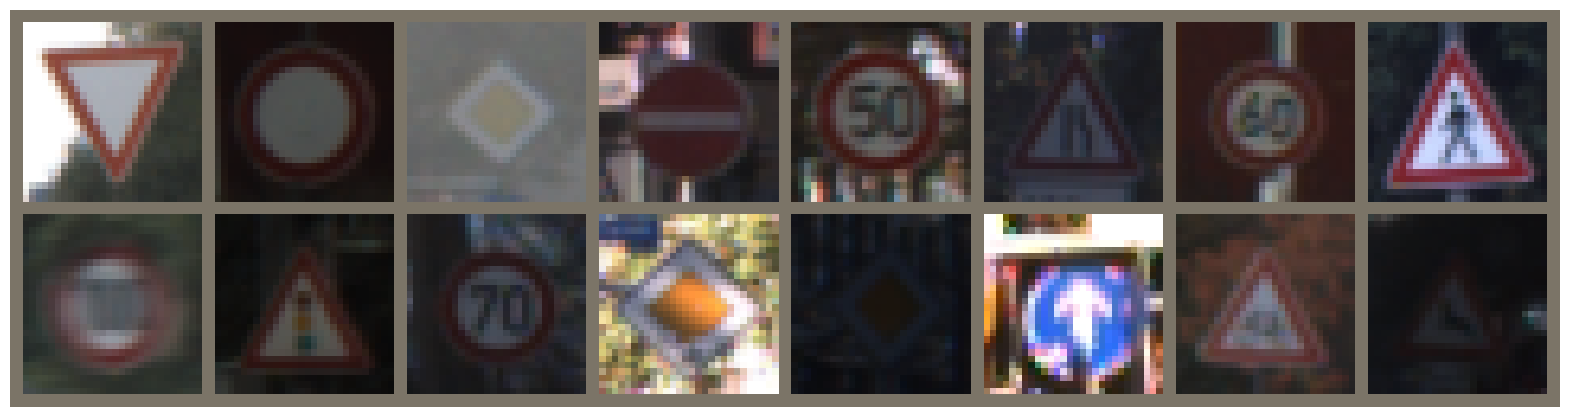

In [4]:
# Check the shapes of the batch data in train_loader
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

# Check a few images of some images
# Ensure you have inverse the normalization before plotting.
imgs = torchvision.utils.make_grid(x[:16])
imgs = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)(imgs)
plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(imgs.numpy(), (1, 2, 0)))
plt.axis("off")
plt.show()

<div class="alert alert-block alert-info">
    
## Task 3.3: Define a CNN Model <a class="anchor" id="t3_3"></a>
    
Define the models using the LightningModule class as usual.

In [5]:
# We will use modular convolutional blocks.
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.


class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out, channels_hidden=8, dropout=0.2):
        super(ConvBlock, self).__init__()  # Call constructor
        self.conv1 = nn.Conv2d(channels_in, channels_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels_hidden, channels_out, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        return x


# Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):

    def __init__(
        self, num_classes=43, learning_rate=1e-3, conv_channels=[16, 32], fc_neurons=128
    ):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()

        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(3, conv_channels[0])
        self.conv_blk2 = ConvBlock(conv_channels[0], conv_channels[1])

        # You can use other layers too, feel free to define them here

        # You will need to define your fully connected layer:
        self.fc1 = nn.Linear(conv_channels[1] * 7 * 7, fc_neurons)
        self.fc2 = nn.Linear(fc_neurons, self.num_classes)

        # Define your accuracies
        self.train_acc = Accuracy(
            task="multiclass", num_classes=self.num_classes, average="micro"
        )
        self.val_acc = Accuracy(
            task="multiclass", num_classes=self.num_classes, average="micro"
        )
        self.test_acc = Accuracy(
            task="multiclass", num_classes=self.num_classes, average="micro"
        )

    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def on_train_start(self) -> None:
        for l in self.loggers:
            if isinstance(l, TensorBoardLogger):
                l.log_hyperparams(self.hparams_initial)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.train_acc.update(logits, y)
        log_dict = {"train_loss": loss, "train_acc": self.train_acc}
        self.log_dict(log_dict, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.val_acc.update(logits, y)
        log_dict = {"val_loss": loss, "val_acc": self.val_acc}
        self.log_dict(log_dict, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.test_acc.update(logits, y)
        log_dict = {"test_loss": loss, "test_acc": self.test_acc}
        self.log_dict(log_dict, on_step=False, on_epoch=True, prog_bar=True)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
## Task 3.4: Train and evaluate CNN model <a class="anchor" id="t3_4"></a>
    
Define VisualizeSamplePredictionsCallback using Callback class. You have to visualise 4 sample predictions from the first batch at the end of testing. This will redefine the on_test_batch_end function.

Here is a sample image:
    
<img src="figures/sample_predictions_reel.png" width="700" align="center">

Make sure to display actual category of Ground truth and Prediction by reading the given text file.
   
    
In PyTorch Lightning, callback functions are used to customize and extend the behavior of your training loops without cluttering your main code. Callbacks are objects that you can attach to your LightningModule and customize various aspects of the training process, such as logging, early stopping, model checkpointing, and more. We are updating the callback of the  the _on_test_batch_end method derived from the pytorch lightning module.

In [6]:
class VisualizeSamplePredictionsCallback(Callback):

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the test batch ends."""

        # `outputs` comes from `LightningModule.test_step`, so make sure to return prediction in test_step
        # which corresponds to our model predictions during testing time in this case
        # Let's log 4 sample image predictions from first batch
        # Make sure to do inverse normalizing before you plot original images
        # Also, make sure to display corresponding actual class name for ground truth and prediction

        # You can ignore the input "dataloader_id"
        if batch_idx == 0:

            x, y = batch

            # # If you are using cuda, then you need to use the three lines below
            # x = x.cpu()
            # y = y.cpu()
            # outputs = outputs.cpu()

            fig, ax = plt.subplots(1, 4, figsize=(20, 20))

            # Apply your inverse normalization before plotting
            for i in range(4):
                img = transforms.Normalize(
                    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
                )(x[i])
                ax[i].imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
                ax[i].axis("off")
                pred = outputs[i].argmax()
                ax[i].set_title(
                    f"Ground truth: {y[i]} - {categories[y[i]]}\nPrediction: {pred} - {categories[pred]}"
                )
            plt.show()

In [7]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [8]:
# Initialize the CNN model
max_epochs = 100  # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints_section_3/",
    save_top_k=1,
    mode="min",
    every_n_epochs=1,
)

# Stop after 5 epochs of no improvement in validation loss
early_stopping = EarlyStopping("val_loss", patience=5, mode="min")

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else "cpu",  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[
        TQDMProgressBar(refresh_rate=20),
        checkpoint_callback,
        VisualizeSamplePredictionsCallback(),
    ],
    logger=[
        CSVLogger(save_dir="logs_task_3"),
        TensorBoardLogger(save_dir="logs_task_3", default_hp_metric=False),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
pl.utilities.model_summary.summarize(model_cnn)

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | CrossEntropyLoss   | 0      | train
1 | conv_blk1 | ConvBlock          | 1.4 K  | train
2 | conv_blk2 | ConvBlock          | 3.5 K  | train
3 | fc1       | Linear             | 200 K  | train
4 | fc2       | Linear             | 5.5 K  | train
5 | train_acc | MulticlassAccuracy | 0      | train
6 | val_acc   | MulticlassAccuracy | 0      | train
7 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.845     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode

In [10]:
# Train the model
# trainer_task.fit(model_cnn)

You are using a CUDA device ('AMD Radeon RX 7900 XTX') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lucas/code/ece4179-neural-networks/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

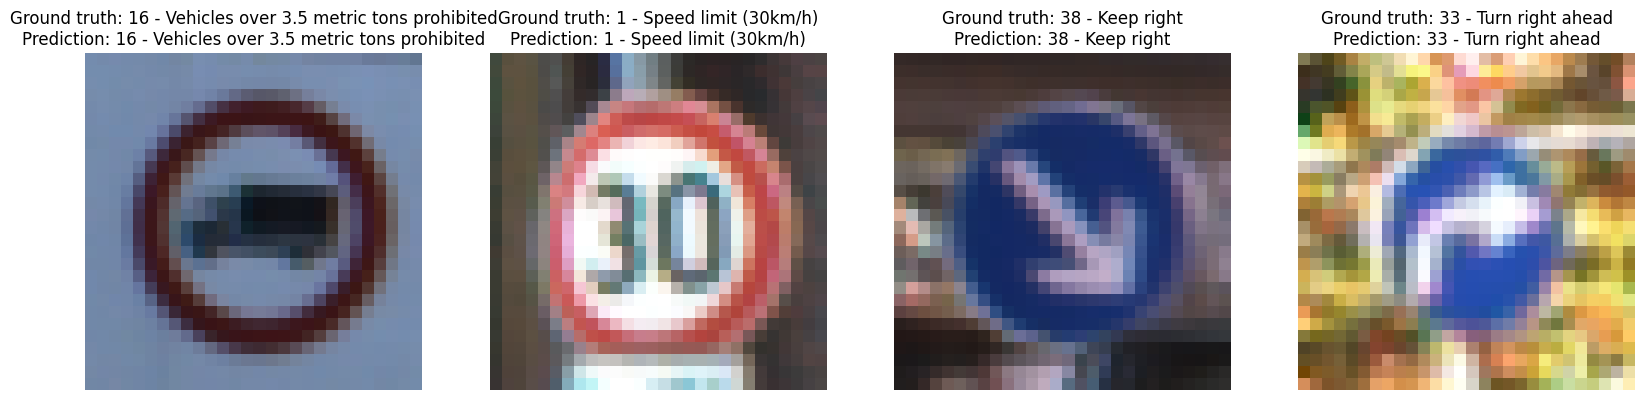

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9374505281448364
        test_loss           0.3473595678806305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3473595678806305, 'test_acc': 0.9374505281448364}]

In [11]:
# Test the model and report test accuracy and test loss
params = torch.load("checkpoints_section_3/epoch=80-step=6804.ckpt")
model_cnn.load_state_dict(params["state_dict"])
trainer_task.test(model_cnn)

<div class="alert alert-block alert-info">
    
## Task 3.5: Visualise the results and apply additional analysis here <a class="anchor" id="t3_5"></a>

Using log files and matplotlib, plot train loss, validation loss, train accuracy, and validation accuracy.

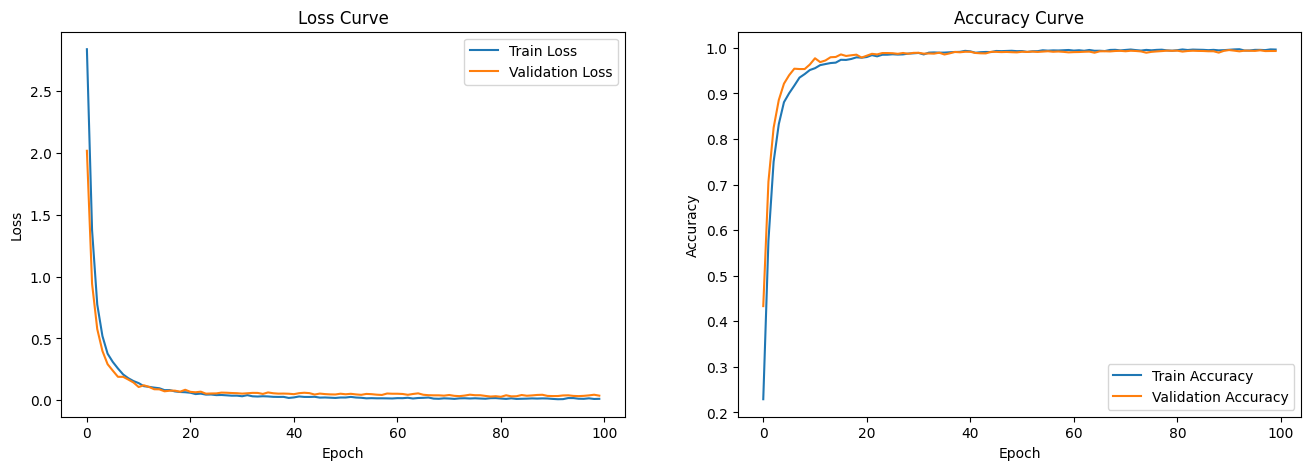

In [12]:
# Show the CNN training and validation curves.
# You can use your own way of logging if you do not want to use tensorboard.
metrics_task = pd.read_csv("logs_task_3/lightning_logs/version_0/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = (
    metrics_task.groupby(level=0)
    .sum()
    .drop("step", axis=1)
    .drop(metrics_task.tail(1).index)
)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics_task["train_loss"], label="Train Loss")
plt.plot(metrics_task["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(metrics_task["train_acc"], label="Train Accuracy")
plt.plot(metrics_task["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy Curve")
plt.show()

Add in your other analysis here. You can choose two (or more) of the following (or any others that are not on this list):

- Feature maps at the outputs of each __CNN block__ for a correctly classified road sign
- Saliency map on a correctly classified road sign
- Top 5 incorrectly classified road signs
- Occlusion sensitivity on a few images
- Confusion matrix on a subset of classes (~15 classes)

# Saliency map of correctly classified road sign

index 13


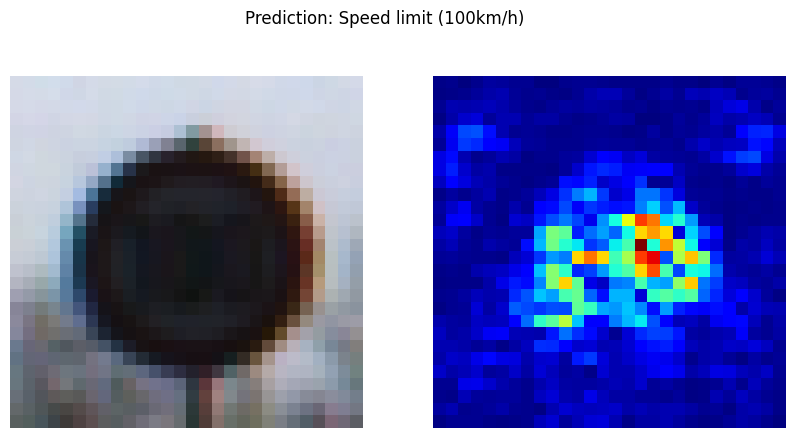

In [30]:
model_cnn.eval()
x, y = next(iter(test_loader))
logits = model_cnn(x)
preds = logits.argmax(dim=1)
c_idx = torch.eq(preds, y)

c_y = y[c_idx]
c_x = x[c_idx]
c_preds = preds[c_idx]
i = random.randint(0, len(c_y) - 1)
i = 13
print("index", i)

e_x = c_x[i]
e_y = c_y[i]
e_pred = c_preds[i]

e_input = e_x.unsqueeze(0)
e_input.requires_grad = True
e_logits = model_cnn(e_input)
e_pred = e_logits.argmax()
e_max = e_logits[0, e_pred]
e_max.backward()

sal, _ = e_input.grad.abs().max(dim=1)
plt.figure(figsize=(10, 5))
plt.suptitle(f"Prediction: {categories[e_pred]}")
plt.subplot(1, 2, 1)
img = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)(e_x)
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sal.squeeze().detach().cpu(), cmap="jet")
plt.axis("off")
plt.show()

# Feature maps of correctly classified images

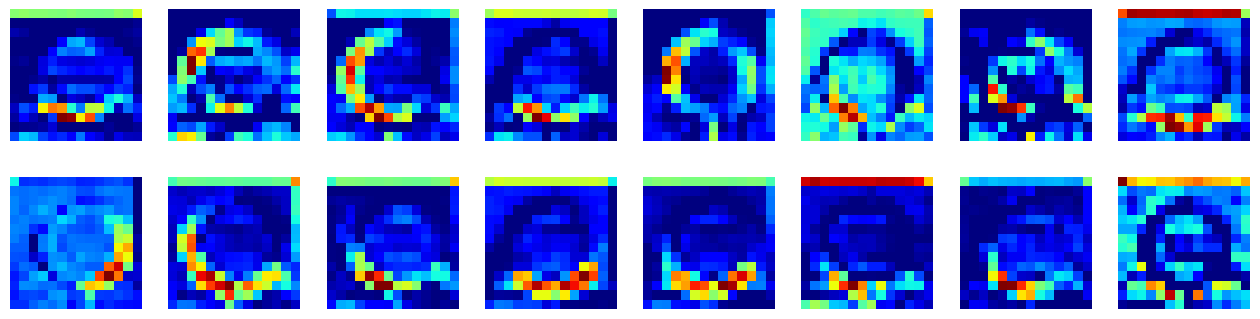

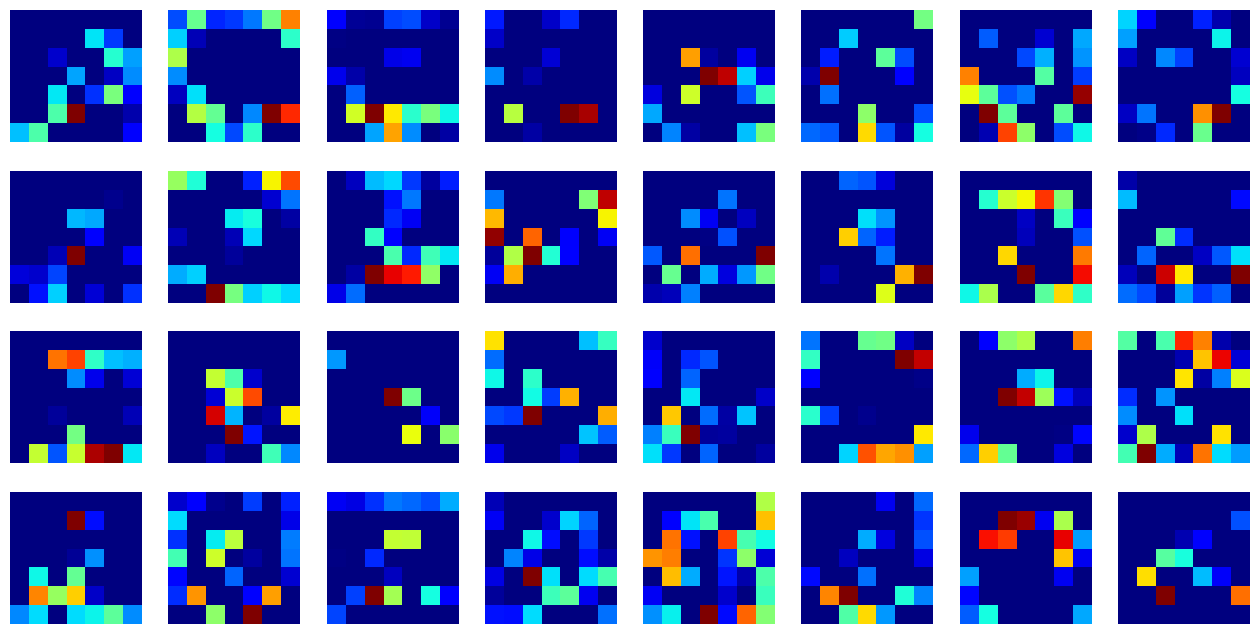

In [31]:
def visualize_feature_maps(fm: torch.Tensor):
    m = fm.squeeze().detach().cpu()
    rows = m.size(0) // 8
    plt.figure(figsize=(16, 2 * rows))
    for i in range(m.size(0)):
        plt.subplot(rows, 8, i + 1)
        plt.imshow(m[i], cmap="jet")
        plt.axis("off")


fm1 = model_cnn.conv_blk1(e_input)
fm2 = model_cnn.conv_blk2(fm1)
visualize_feature_maps(fm1)
visualize_feature_maps(fm2)

<div class="alert alert-block alert-success">
    
## Task 3.6: Discussion Questions <a class="anchor" id="t3_6"></a>
    
## Questions
    
1. List the different ways you have tried to optimize your model and discuss why you chose those methods.

2. Show how you calculated the input size of the fully connected layer right after all the convolutional blocks. 

3. Please talk and discuss about the first additional analysis you have performed. What can you deduce from the analysis?

4. Please talk and discuss about the second additional analysis you have performed. What can you deduce from the analysis?
    

    
## Answers

1. Methods for optimizing the model involved changing the hyperparameters passed to the model. These included:
  - learning rate
  - convolutional block output channels
  - fully connected hidden neurons

The convolution channels and hidden neurons were adjusted to maintain a balance between training time, model complexity, possibility for overtraining, and model accuracy.
The final values seem to find a decent balance, given that the validation and train accuracies tracked similarly, and test accuracy was not too far behind, while the number of model parameters was kept fairly small.  
Learning rate was adjusted to find values that would converge the fastest without overshoot.

2. The input size of the fully connected layer after all the convolutional blocks was given by the number of output feature maps multiplied by the height and width of those output feature maps.
The number of output feature maps was set to 32.
The dimensions of the feature maps was equal to 28/2/2 because there was one 2x2 max pooling layer in each convolutional block and the convolutional layers maintained image sizes with kernel sizes of 3x3 and 1 pixel of padding.

3. The first analysis was a saliency map of a correct prediction.
From the saliency map we can see that the model focuses its attention on the sign itself as expected.
For this image in particular, which is a 100km/h speed limit sign, it seems to focus especially on the number within the sign, which makes sense given that it also has to differentiate between other speed limit signs which can contain different numbers.

4. The second analysis was a visualisation of the feature maps generated by each convolutional block.
The first convolutional block seems encode information that is still recognisable as features like lines and colour differences within the image.
After the second convolutional block, the feature maps are so compressed that very little can be discerned by a human.
It seems however that the fully connected layers after can make good use of whatever information is contained there.
